In [153]:
%cd СОВМЕЩЕНИЕ ПРЕДСКАЗАНИЙ

In [154]:
!ls

ARG.npy                            pic_q_1.png
ARG.npy.zip                        pic_q_5.png
VAL.npy                            prediction_aggregation.ipynb
VAL.npy.zip                        prediction_aggregation_1.ipynb
__pycache__                        sch_multiple_pred_data_creation.py
chain_segment_chi_prediction       sidechain_builder
data_2phase.png                    w_le_best.pth
data_2phase_2.png                  w_le_best_01.pth
model_01.pth                       w_le_nn_1.pth
model_bn.pth                       w_le_nn_2.pth
nn_1_weights_le.pth                ww1
nn_1_weights_le_1_1.pth            ww1.png
nn_1_weights_le_2.pth              ww2
nn_3_le.pth                        ww2.png
nn_4_le.pth


In [155]:
!pip install Bio

In [156]:
from chain_segment_chi_prediction.prediction_aggregation import ChiPredictionAggregator
from chain_segment_chi_prediction.ml_wrapping import MLModelWrapper
from sch_multiple_pred_data_creation import DataCreator
from sidechain_builder.config import SideChain
import numpy as np
import Bio.PDB as pdb
from tqdm.notebook import tqdm

# Методология:

1. Для N=1000 samples одной аминокислоты собираем матрицы предсказаний из разных сэмплов модели ML. Получаем X - матрицу входа размером (Nx64x36) и y - вектор длины N с оригинальными значениями $chi_1$ для каждого сэмпла

2. Получаем веса weights.

# ПЕРВЫЕ ДВА БЛОКА ЗАПУСКАТЬ НЕ НУЖНО. <a href="#agg">ПЕРЕЙТИ К АГРЕГАЦИИ</a>

# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ

In [ ]:
FEATURES_TO_FETCH = ["resname", 
                "polarity_group", 
                "hydropathy_group", 
                "volume_group", 
                "chemical_group", 
                "physicochemical_group", 
                "charge_group", 
                "hydrogen_donor_acceptor_group"]

In [ ]:
import json
with open("../../pspredictor/resources/amino_acid_features.json") as f:
    res_features = json.loads(f.read())
with open("../../pspredictor/resources/aminoacid_angle_atoms.json") as f:
    chi_atoms = json.loads(f.read())

In [ ]:
def count_feature_num(num_residues):
    M = sum([np.unique([v[fea] for k,v in res_features.items()]).shape[0] for fea in FEATURES_TO_FETCH])
    M += 8 + num_residues + 36 + 36
    return M

def get_classification_features(residue):
    features = FEATURES_TO_FETCH
    all_values = [np.unique([v[fea] for k,v in res_features.items()]).tolist() for fea in features]
    ans = np.empty(0)
    resname = residue.resname
    for i in range(len(features)):
        fea_ans = np.zeros(len(all_values[i]))
        fea_ans[all_values[i].index(res_features[resname][features[i]])] = 1
        ans = np.hstack((ans, fea_ans))
    return ans

def get_backbone_features(chain, dssp_result, res_ind):
    # DSSP
    all_dssp_values = ["H", "B", "E", "G", "I", "T", "S", "-"]
    ans = np.zeros(len(all_dssp_values))
    ans[all_dssp_values.index(dssp_result[(chain[res_ind].parent.get_id(), 
                                           chain[res_ind].get_id())][2])] = 1
    # phi
    phi_ans = np.zeros(36)
    if res_ind > 0:
        phi_val = pdb.calc_dihedral(chain[res_ind-1]["C"].get_vector(),
                                    chain[res_ind]["N"].get_vector(),
                                    chain[res_ind]["CA"].get_vector(),
                                    chain[res_ind]["C"].get_vector())
        phi_val = max(min(int(phi_val // (2*np.pi/36)), 17), -18)
        phi_ans[phi_val] = 1
    else:
        # if no phi can be computed, just set to 0'th bin
        # TODO: maybe 18'th? (phi = 0)
        phi_ans[0] = 1
    ans = np.hstack((ans, phi_ans))
    
    # psi
    psi_ans = np.zeros(36)
    if res_ind < len(chain) - 1:
        psi_val = pdb.calc_dihedral(chain[res_ind]["N"].get_vector(),
                                    chain[res_ind]["CA"].get_vector(),
                                    chain[res_ind]["C"].get_vector(),
                                    chain[res_ind+1]["N"].get_vector())
        psi_val = max(min(int(psi_val // (2*np.pi/36)), 17), -18)
        psi_ans[psi_val] = 1
    else:
        # if no phi can be computed, just set to 0'th bin
        # TODO: maybe 18'th? (phi = 0)
        psi_ans[0] = 1
    ans = np.hstack((ans, psi_ans))
    
    return ans

def create_dist_matrix(chain, by_atom="CA"):
    matr = np.zeros((len(chain), len(chain)))
    for i in range(len(chain) - 1):
        for j in range(i+1, len(chain)):
            matr[i,j] = matr[j,i] = chain[i][by_atom if chain[i].has_id(by_atom) else "CA"] - chain[j][by_atom if chain[j].has_id(by_atom) else "CA"]
    return matr


def get_chi_distribution(residue, angle_num=1):
    if angle_num != 1:
        raise Exception("Not currently implemented!")
    # ans = np.zeros((1,36))
    if residue.resname in ["ALA", "GLY"]:
        return np.zeros((1,36))
    chi_val = pdb.calc_dihedral(*[residue[at_name].get_vector() for at_name in chi_atoms[residue.resname][angle_num - 1]])
    chi_val = chi_val / np.pi * 180
    y_bounds = np.arange(-180, 181, 10)
    return np.array([[1 if (y_bounds[k] <= chi_val <= y_bounds[k+1]) else 0 for k in range(len(y_bounds) - 1)]])

def fetch_sample(chain, dssp_result, i_start, num_residues):
    M = count_feature_num(num_residues)
    ans = np.zeros((num_residues, M))
    y_ans = np.zeros((num_residues, 36))
    ind_stop = None
    for i in range(i_start, i_start + num_residues):
        if i >= len(chain):
            ind_stop = i - i_start
            break
        row = get_classification_features(chain[i])
        row = np.hstack((row, get_backbone_features(chain, dssp_result, i)))
        ans[i - i_start, 0:len(row)] = row
        y_ans[i - i_start] = get_chi_distribution(chain[i])
        # print("distrib sum:", get_chi_distribution(chain[i]).sum())
    if ind_stop is None:
        ind_stop = num_residues
    
    # normed contact matrix
    dist_matr = create_dist_matrix(chain[i_start:i_start + num_residues])
    dist_matr[dist_matr > R] = 0
    dist_matr /= R
    ans[:ind_stop, len(row):len(row) + ind_stop] = dist_matr
    
    
    return ans, y_ans

# Сбор данных

In [ ]:
import json
with open("./side-chain-multiple-data-extended_no_padding/filenames.json") as f:
    filenames = json.loads(f.read())

In [ ]:
NUM_TRAIN_SAMPLES = 1000
NUM_TEST_SAMPLES = 400
# PDB_PATH = "/Volumes/Seagate/PDB/ftp.wwpdb.org/pub/pdb/data/structures/divided/pdb/"
PDB_PATH = "/Volumes/Scishare/PDB/ftp.wwpdb.org/pub/pdb/data/structures/divided/pdb/"

In [ ]:
import numpy as np
train_pdbs = list(set([name.split("/")[-1].split("_")[0] for name in filenames["train"]]))
test_pdbs = list(set([name.split("/")[-1].split("_")[0] for name in filenames["test"]]))
np.random.shuffle(train_pdbs)
np.random.shuffle(test_pdbs)

In [ ]:
def get_agg_sample(fetcher, tgt_ind):
    ans = [] # np.zeros((64, 64, count_feature_num(64)))
    
    i_start_begin = max(tgt_ind - 64 + 1, 0)
    i_start_end = min(tgt_ind + 1, len(fetcher._chain) - 64)
    step = 1
    for i_start in range(i_start_begin, i_start_end, step):
        sample = fetcher.get_sample(i_start, 64)
        ans += [sample]
    chi1_orig = SideChain(fetcher._chain[tgt_ind].resname, 
                          {}, 
                          pdb_residue=fetcher._chain[tgt_ind]).get_dihedrals()["chi1"]
    return (ans, i_start_begin, tgt_ind, chi1_orig)

In [ ]:
def collect_samples(pdb_ids, resname, num_samples=1000):
    features_to_fetch = ["resname", 
                     "polarity_group", 
                     "hydropathy_group", 
                     "volume_group", 
                     "chemical_group", 
                     "physicochemical_group", 
                     "charge_group", 
                     "hydrogen_donor_acceptor_group"
                    ]
    import json
    with open("../../pspredictor/resources/amino_acid_features.json") as f:
        res_features = json.loads(f.read())
    parser = pdb.PDBParser()
    samples = []
    with tqdm(total=num_samples) as tbar:
        for pdb_id in pdb_ids:
            path = PDB_PATH + pdb_id[1:3] + "/pdb" + pdb_id + ".ent"
            try: 
                fetcher = DataCreator(path, features_to_fetch, res_features, constants={"R": 10})
            except:
                print(f"Couldn't open {pdb_id}")
                continue

    #         dssp_result = dict(pdb.DSSP(struct[0], path))
    #         get_agg_sample(fetcher, )
            for i in range(len(fetcher._chain)):
                if fetcher._chain[i].resname != resname:
                    continue
                try:
                    samples += [get_agg_sample(fetcher, i)]
                    tbar.update(1)
                except Exception as e:
                    raise e
                    continue
                if len(samples) >= num_samples:
                    break
#             print(f"After {pdb_id}: {len(samples)}")
            if len(samples) >= num_samples:
                break
    return samples

In [ ]:
amacids = list(res_features.keys())
amacids = amacids[amacids.index("THR"):]
amacids

['THR', 'TRP', 'TYR', 'VAL']

In [ ]:
for resname in amacids:
    if resname in ["ALA", "GLY"]:
        continue
    print(resname)
    train_data = collect_samples(train_pdbs, resname, NUM_TRAIN_SAMPLES)
    test_data = collect_samples(test_pdbs, resname, NUM_TEST_SAMPLES)
    res_data = {"train": train_data, 
                "test": test_data}
    np.save(f"./agg_data/{resname}.npy", res_data)
    del res_data
    del train_data
    del test_data

THR



TRP


/usr/local/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'ATO   ' at line 1518
  warnings.warn(



TYR


/usr/local/lib/python3.8/site-packages/Bio/PDB/vectors.py:357: RuntimeWarning: invalid value encountered in double_scalars
  c = (self * other) / (n1 * n2)



VAL


In [ ]:
with open("../../pspredictor/resources/amino_acid_features.json") as f:
        res_features = json.loads(f.read())

In [ ]:
res_features.keys()

dict_keys(['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'])

# <a name="agg"></a> АГРЕГАЦИЯ ПРЕДСКАЗАНИЙ

### Методология:

Для каждой аминокислоты:
    
    Для каждого сэмпла из выборки agg_data:
    
        Предсказываем моделью ML результат для каждого sub-сэмпла.
        
        Агрегируем все предсказания в матрицу, дозаполняем нулями.
        
    Собираем все таблицы; фиттим веса для агрегации.

## Предсказание в два этапа

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import Bio.PDB as pdb
import json
from torch.nn import LSTM, Conv2d, Conv1d, Linear, Dropout, Sequential, Module, MaxPool2d, AvgPool2d, Flatten, BCELoss, Sigmoid, ReLU, Dropout2d, Dropout
from torch import cat, Tensor, reshape
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn import functional as F
from torch import nn
from keras.models import load_model
import tensorflow as tf

In [158]:
RESNAME = "VAL"

In [159]:
res_data = np.load(f"{RESNAME}.npy", allow_pickle=True)
X_train = res_data.item()["train"]
X_test = res_data.item()["test"]
del res_data

In [160]:
# def proceed_samples(X, md_wrapper):
#     out_X, out_y = np.empty((0, 64, 36)), np.empty(0)
#     print("Processing samples:")
#     for samp in tqdm(X):
#         samp_out = np.zeros((64, 36))
#         subsamps, i_start_begin, tgt_ind, chi1_orig = samp
#         for i in range(len(subsamps)):
#             X_new = None
#             flag = True
#             pred_ind = 0
#             for ind in ar_dims:
#                 x_temp = subsamps[i][0][0].T[pred_ind:pred_ind + ind].T
#                 x_temp_2 = np.argmax(x_temp, axis=1)
#                 pred_ind += ind
#                 if flag:
#                     X_new = x_temp_2.reshape(1, -1)
#                     flag = False
#                 else:
#                     X_new = np.vstack([X_new, x_temp_2.reshape(1, -1)])
#             print(X_new.shape)


#             pred = md_wrapper.predict(torch.from_numpy(X_new).float())[0]
#             tgt_line_ind = tgt_ind - i_start_begin - i
#             tgt_line = pred[tgt_line_ind]
#             samp_out[tgt_line_ind] = tgt_line / np.sum(tgt_line)
#         out_X = np.append(out_X, [samp_out], axis=0)
#         if chi1_orig > np.pi:
#             chi1_orig -= 2*np.pi
#         out_y = np.append(out_y, chi1_orig)
#     return out_X, out_y

In [161]:
class DataGenerator(Dataset):
    def __init__(self, wX, wy):
        self.batch_size = 1
        self.wX = wX
        self.wy = wy

    def __len__(self):
        return (np.ceil(len(self.wX) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx):
        batch_x = self.wX[idx * self.batch_size:(idx+1) * self.batch_size]
        batch_y = self.wy[idx * self.batch_size:(idx+1) * self.batch_size]
        ymod = (batch_y + 2*np.pi) % (2*np.pi)
        y_bin = np.array(ymod / (np.pi / 18), dtype=int)
        batch_y = y_bin
        # print(batch_x.shape)
        # print(batch_y)
        return Tensor(batch_x), Tensor(batch_y)

### Модель Linear x3 для categorical features + embedding

In [162]:
class Net_lin_2(nn.Module):
    def __init__(self, embedding_sizes, n_cont = 64):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb, 128)
        self.lin2 = nn.Linear(128, 64)
        self.lin3 = nn.Linear(64, 36)
        self.bn2 = nn.BatchNorm1d(64)
        self.out = Sigmoid()
        

    def forward(self, x_cat, x_cont):
        x_temp = x_cat.permute(1, 2, 0)
        x = []
        for i, e in enumerate(self.embeddings):
            x.append(e(x_temp[i].T))
        x = torch.cat(x, 2)
        x = F.relu(self.lin1(x))
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        x = self.out(x)
        return x

In [163]:
ar_dims = np.array([20, 2, 3, 5, 7, 11, 3, 4, 8, 36, 36])
ar_dims
embedding_sizes = []
for i in range(11):
    embedding_sizes.append((ar_dims[i], (ar_dims[i] + 1) // 2))

In [164]:
start_model = Net_lin_2(embedding_sizes, 64)
start_model.load_state_dict(torch.load('nn_3_le.pth'))
optimizer = Adam(start_model.parameters())
loss_func = nn.BCELoss()

In [165]:
def proceed_samples(X, md_wrapper):
    out_X, out_y = np.empty((0, 64, 36)), np.empty(0)
    print("Processing samples:")
    for samp in tqdm(X):
        samp_out = np.zeros((64, 36))
        subsamps, i_start_begin, tgt_ind, chi1_orig = samp
        for i in range(len(subsamps)):
            X_new = None
            flag = True
            pred_ind = 0
            for ind in ar_dims:
                x_temp = subsamps[i].T[pred_ind:pred_ind + ind].T
                x_temp_2 = np.argmax(x_temp, axis=1)
                pred_ind += ind
                if flag:
                    X_new = x_temp_2.reshape(1, -1)
                    flag = False
                else:
                    X_new = np.vstack([X_new, x_temp_2.reshape(1, -1)])
            
            pred = md_wrapper.predict(torch.from_numpy(X_new).unsqueeze(0))[0]
            tgt_line_ind = tgt_ind - i_start_begin - i
            tgt_line = pred[tgt_line_ind]
            samp_out[tgt_line_ind] = tgt_line.detach().numpy() / np.sum(tgt_line.detach().numpy())
        out_X = np.append(out_X, [samp_out], axis=0)
        if chi1_orig > np.pi:
            chi1_orig -= 2*np.pi
        out_y = np.append(out_y, chi1_orig)
    return out_X, out_y

In [166]:
class MLModelWrapper:
    def __init__(self, md_instance, is_keras):
        self._md = md_instance
        self._md_is_keras = is_keras

    def predict(self, X):
        if self._md_is_keras:
            return self._md.predict(X)
        else:
            return self._md.forward(X, None)

In [167]:
wrapper = MLModelWrapper(start_model, False)
wX, wy = proceed_samples(X_train, wrapper)

Processing samples:


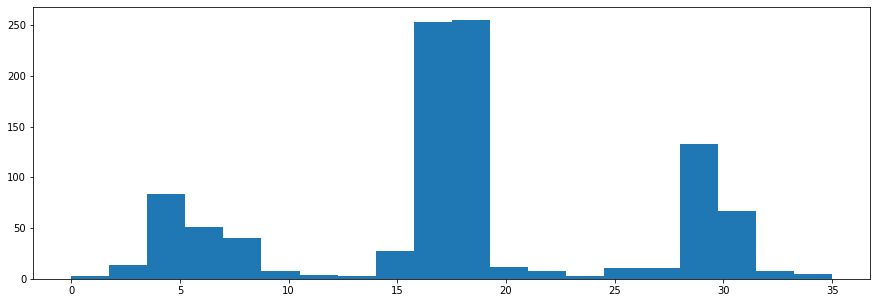

In [22]:
wy_bins = np.array(((wy + 2*np.pi) % (2*np.pi)) / (np.pi / 18), dtype=int)
plt.figure(figsize=(15,5))
plt.hist(wy_bins, 20)
plt.savefig('data_2phase.png')

### NN1

In [23]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = x.reshape(x.shape[0], 64 * 36)
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        
        return x

In [169]:
train_set = DataGenerator(wX, wy)
train_generator = DataLoader(train_set, 
                             batch_size=16, 
                             shuffle=True)

In [25]:
model_1 = MulticlassClassification(num_feature = 2304, num_class=36)

In [26]:
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model_1.parameters(), lr=0.0001)

In [170]:
# wX, wy = proceed_samples(X_test, wrapper)

Processing samples:


In [171]:
# test_set = DataGenerator(wX, wy)
# test_generator = DataLoader(test_set, 
#                              batch_size=1, 
#                              shuffle=False)

In [172]:
len(train_set), len(test_set)

(1000, 400)

In [37]:
model_1.train()
for k in range(10): #+ 50
  for i, (X, y) in enumerate(train_generator):
      optimizer.zero_grad()
      y_pred = model_1(X)
      pred_loss = loss_func(y_pred, y.reshape(-1).long())
      pred_loss.backward()
      torch.nn.utils.clip_grad_norm_(model_1.parameters(), 1)#
      optimizer.step()
      if i % 300:
        print(pred_loss.item())
  model_1.eval()
  predictions = []
  j = 0 # считаем правильные ответы с diff = 3
  with torch.no_grad():
    for X, y in test_generator:
      pred = model_1(X)
      pred = nn.Softmax(dim=1)(pred)
      predictions.append(pred)
      if np.abs(np.argmax(pred.cpu()) - y) <=6 or (36 - np.abs(np.argmax(pred.cpu()) - y)) <=6:
        j+= 1
  print(k, j / 400)

2.3837480545043945
2.2689499855041504
2.2791523933410645
2.3227241039276123
2.467061996459961
2.4820990562438965
2.4572184085845947
2.252142906188965
2.223191976547241
2.4231624603271484
2.20676851272583
2.352621078491211
2.3193085193634033
2.498415946960449
2.099484443664551
2.26615571975708
2.16286563873291
2.242274522781372
2.190244197845459
2.1557304859161377
2.3870952129364014
2.4916293621063232
2.08791446685791
2.2235107421875
2.2411491870880127
2.3382744789123535
2.4346537590026855
2.558319330215454
2.213312864303589
2.1826395988464355
2.239917755126953
2.053548812866211
2.4621880054473877
2.485485315322876
2.260559558868408
2.2848658561706543
2.3442859649658203
2.2993836402893066
2.245662212371826
2.484825849533081
2.4497976303100586
2.062286615371704
2.271146059036255
2.4047021865844727
2.147475481033325
2.422858476638794
2.3588294982910156
2.102085828781128
2.345825672149658
2.1087441444396973
2.3012359142303467
2.271059989929199
2.431185483932495
2.3521647453308105
2.4342026

In [38]:
model_1.eval()
predictions = []
i = 0 # считаем правильные ответы с diff = 3
with torch.no_grad():
    for X, y in test_generator:
      pred = model_1(X)
      pred = nn.Softmax(dim=1)(pred)
      predictions.append(pred)
#       if np.abs(np.argmax(pred.cpu()) - y) <=6 or 36 - (np.abs(np.argmax(pred.cpu()) - y)) <=6:
      if np.abs(np.argmax(pred.cpu()) - y) <=3:
        i+= 1

In [39]:
i / 400

0.6125

In [558]:
# torch.save(model_1.state_dict(), 'nn_1_weights_le_1_1.pth')

In [223]:
qq = []
for i in range(400):
  t = np.abs(np.argmax(predictions[i].cpu().numpy()) - int(test_set[i][1].numpy()[0]))
  qq += [min(t, 36 - t)]
qp = np.quantile(qq, 0.75)
plt.hist(qq, bins=9)
plt.plot([qp, qp], [0, 200])
plt.savefig('pic_q_1.png')


### NN 2

In [41]:
class Net_w(Module):
    def __init__(self):
        super().__init__()
        self.lin1 = Linear(in_features=2304, out_features=1024)
        self.act1 = ReLU()
        self.lin2 = Linear(in_features=1024, out_features=256)
        self.act2 = ReLU()
        self.lin3 = Linear(in_features=256, out_features=36)
        
    def forward(self, x):
        out = x.reshape(x.shape[0], 64 * 36)
        out = self.lin1(out)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        out = self.lin3(out)
        return out

In [42]:
model_2 = Net_w()
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model_2.parameters())

In [225]:
model_2.train()
for k in range(30):
  for i, (X, y) in enumerate(train_generator):
      optimizer.zero_grad()
      y_pred = model_2(X)
      pred_loss = loss_func(y_pred, y.reshape(-1).long())
      pred_loss.backward()
      torch.nn.utils.clip_grad_norm_(model_2.parameters(), 1)#
      optimizer.step()
      if i % 50:
        print(pred_loss.item())

In [50]:
model_1.eval()
predictions = []
i = 0 # считаем правильные ответы с diff = 3
with torch.no_grad():
    for X, y in test_generator:
      pred = model_1(X)
      pred = nn.Softmax(dim=1)(pred)
      predictions.append(pred)
#       if np.abs(np.argmax(pred.cpu()) - y) <=6 or 36 - (np.abs(np.argmax(pred.cpu()) - y)) <=6:
      if np.abs(np.argmax(pred.cpu()) - y) <=3:
        i+= 1

In [51]:
i / 400

0.625

### NN 3

In [193]:
class Net1_cnn(Module):
    def __init__(self):
        super().__init__()

        self.conv1 = Conv2d(1, 32, kernel_size=3)
        self.act1 = ReLU()
        self.pool1 = MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv2 = Conv2d(32, 16, kernel_size=3)
        self.act2 = ReLU()

        self.conv3 = Conv2d(16, 8, kernel_size=3)
        self.act3 = ReLU()


        self.flatten = Flatten()
        self.lin1 = Linear(2808, 36)

        
    def forward(self, x):
        x = x.reshape(x.shape[0], 1,  64, 36)

        out = self.conv1(x)
        out = self.act1(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)
        out = self.flatten(out)

        out = self.lin1(out)
        return out

In [194]:
model_3 = Net1_cnn()
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model_3.parameters())

In [149]:
model_3.train()
for k in range(30):
  for i, (X, y) in enumerate(train_generator):
      optimizer.zero_grad()
      y_pred = model_3(X)
      pred_loss = loss_func(y_pred, y.reshape(-1).long())
      pred_loss.backward()
      torch.nn.utils.clip_grad_norm_(model_3.parameters(), 1)#
      optimizer.step()
      if i % 50:
        print(pred_loss.item())


In [216]:
torch.save(model_3.state_dict(), 'aggreg.pth') # 1

In [219]:
model_3.eval()
predictions = []
j = 0
with torch.no_grad():
    for X, y in test_generator:
      pred = model_3(X)
      pred = nn.Softmax(dim=1)(pred)
      predictions.append(pred)
      if np.abs(np.argmax(pred.cpu()) - y) <=3 or (36 - np.abs(np.argmax(pred.cpu()) - y)) <=3:
        j+= 1
print(j / 400)
res_3 = j/400

0.65


In [221]:
model_3.eval()
predictions = []
j = 0
with torch.no_grad():
    for X, y in test_generator:
      pred = model_3(X)
      pred = nn.Softmax(dim=1)(pred)
      predictions.append(pred)
      if np.abs(np.argmax(pred.cpu()) - y) <=6 or (36 - np.abs(np.argmax(pred.cpu()) - y)) <=6:
        j+= 1
print(j / 400)
res_6 = j/400

0.6675


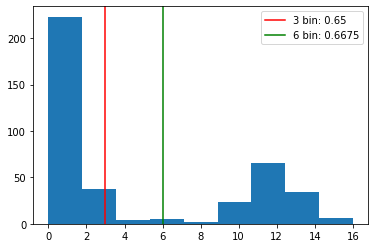

In [230]:
fig, ax = plt.subplots()
qq = []
for i in range(400):
  t = np.abs(np.argmax(predictions[i].cpu().numpy()) - int(test_set[i][1].numpy()[0]))
  qq += [min(t, 36 - t)]
ax.hist(qq, bins=9)
ax.axvline(x=3, label='3 bin: ' + str(res_3), color='r')
ax.axvline(x=6, label='6 bin: ' + str(res_6), color='g')
# plt.plot([qp, qp], [0, 200])
# plt.savefig('pic_q_1.png')
ax.legend()
plt.savefig('pic_q_5.png')